In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mc_generator import *

# Generate a Markov process given transition probability

In this part, I will introduce how to sample a Markov process with known transition probability.

* **Aim**: Generate a Markov process $X_t$; it menas we want to get the value of $X_t$ at time $t=t_1, t_2, \dots, t_n$. 

* **Approach**: Firstly, generate $X_t$. By Markov property, we know the distribution of $X_{t+\Delta t}| X_t$. Then we can generate $X_{t+\Delta t}$.  

## Example 1: Generate a Brownian motion

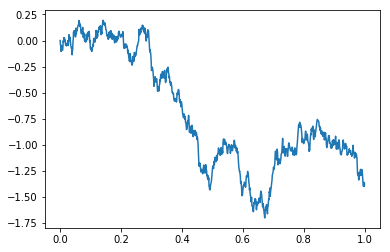

In [2]:
BM = BrownianMotion()
BM.simulate()
BM.figure()

## Example 2: Generate a CIR diffusion

We want to generate $r_t$ which is defined as
$$d r_t = a(b-r_t) dt + \sigma \sqrt{r_t} dW_t.$$
where $a$,$b$, and $\sigma$ are known constant. It is well-known that $r$ is a Markov process and its density is  
$$r_{t+\Delta t}|r_t= \chi^2( \frac{4ab}{\sigma^2}, 2c r_t e^{-a \Delta t} )$$
where $c = \frac{2a}{(1 - e^{-a \Delta t})\sigma^2}$.

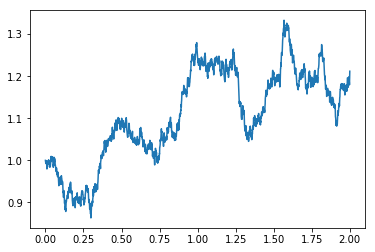

In [3]:
cir = CIR(initial_state=1)
cir.simulate(num_trails=2000, start_time=0.0, end_time=2.0)
cir.figure()

## Example 3: Generate a Poisson process

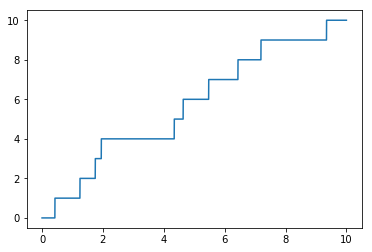

In [4]:
N = Poission()
N.simulate( num_trails=10000, start_time=0.0, end_time=10)
N.figure()

# Generate a couting process with a given intensity $\lambda$

In this part, we consider a more complicated case. Let $N$ be a couting process with compensator $A$.

## Example 4: $A$ doesn't depend on $N$

Assume 
$$A_t = \int^t_0 \lambda_s ds$$
where $\lambda$ is a CIR diffusion. 

* **Question**: How to simulate $N$?

* **Answer**: We can directly sample $K_{A_t}$, where $K$ is a standart Poisson process.

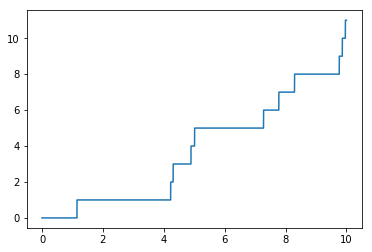

In [15]:
intensity = CIR(initial_state=1)
intensity.simulate(num_trails=5000, start_time=0.0, end_time=10.0)

# Define the time change A_t
def A(t, intensity = intensity):
    time = 0
    A_t = 0
    for s,lambda_s in zip(intensity.time, intensity.simulation):
        A_t += lambda_s * (s - time)
        time = s
        if time > t:
            break
    return A_t

# Sample a Poisson process with a time change;
# Warning: for now, we need to fix the same `num_trails`, `start_time` and `end_time` to keep consistency. I will fix it later.
poisson = Poission(time_change = A)
poisson.simulate(num_trails=5000, start_time=0.0, end_time=10.0)
poisson.figure()

## Example 5: $A$ depends on $N$

Now we assume the dynamics of $\lambda$ is 
$$d r_t = a(b-r_t) dt + \sigma \sqrt{r_t} dW_t + \delta dN_t.$$

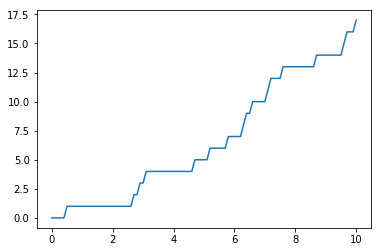

In [26]:
a, b, sigma =1.0, 1.2, 0.2
delta = 0.1

def A(t, intensity = intensity):
    time = 0
    A_t = 0
    for s,lambda_s in zip(intensity.time, intensity.simulation):
        A_t += lambda_s * (s - time)
        time = s
        if time > t:
            break
    return A_t

def trans( current_time, current_state, next_time ):
    new_intensity = CIR(a, b, sigma, initial_state=1)
    new_intensity.simulate(num_trails=100, start_time=0.0, end_time=1.0)
    new_intensity.simulation =  [x + delta * current_state for x in intensity.simulation]
    
    dt = next_time - current_time
    A_t = A(dt, intensity = new_intensity)
    next_jump_time = exponential(1)
    #print(A_t,next_jump_time )
    if next_jump_time<= A_t:
        return current_state+1
    else:
        return current_state

count = MarkovProcess(trans)
count.simulate(num_trails=100, start_time=0.0, end_time=10)
count.figure()

# If we don't know its transition density...

In this part, I will give an example where we cannot get the specific transition probability density.

## Example 6: TODO